In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
LOCAL_DATA_PATH = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/'
import json
# you need to download the scene graph data from visual genome, it's not included in dario's folder (and i don't have write access there)
with open(LOCAL_DATA_PATH+'raw/scene_graphs.json', 'r') as f:
    scene_graphs_dict = json.load(f)

def build_graph(g_dict):
        G = nx.DiGraph(image_id=g_dict['image_id'])
        G.labels = {}
        for obj in g_dict['objects']:
            G.add_node(obj['object_id'], w=obj['w'], h=obj['h'], x=obj['x'], y=obj['y'], attributes=obj.get('attributes',[]), name=obj['names'][0])
            G.labels[obj['object_id']] = obj['names'][0]
        for rel in g_dict['relationships']:
            G.add_edge(rel['subject_id'], rel['object_id'], synsets=rel['synsets'] ,relationship_id=rel['relationship_id'], predicate=rel['predicate'])
        return G
graphs = [] 
for g_dict in tqdm(scene_graphs_dict):
    graphs.append(build_graph(g_dict))

100%|██████████| 108077/108077 [00:37<00:00, 2876.29it/s]


In [2]:
# convert all object labels, attributes and predicates to lower case and remove trailing spaces
for g in tqdm(graphs):
    for n in g.nodes:
        g.nodes[n]['name'] = g.nodes[n]['name'].lower().strip()
        g.nodes[n]['attributes'] = [a.lower().strip() for a in g.nodes[n]['attributes']]
    for e in g.edges:
        g.edges[e]['predicate'] = g.edges[e]['predicate'].lower().strip()


100%|██████████| 108077/108077 [00:31<00:00, 3476.15it/s]


In [3]:
# extract all object labels and all relationship labels and all attribute labels from the graphs
object_labels = {}
relationship_labels = {}
attribute_labels = {}
for g in graphs:
    for obj_label in g.labels.values():
        # # remove trailing spaces
        # obj_label = obj_label.strip().lower()
        object_labels[obj_label] = object_labels.get(obj_label, 0) + 1
    for rel_label in [g.edges[e]['predicate'] for e in g.edges]:
        # rel_label = rel_label.strip().lower()
        relationship_labels[rel_label] = relationship_labels.get(rel_label, 0) + 1
    for attr_label in [g.nodes[n]['attributes'] for n in g.nodes]:
        for a in attr_label:
            # a = a.strip().lower()
            attribute_labels[a] = attribute_labels.get(a, 0) + 1
print(f'number of graphs: {len(graphs)}')
print(f'number of object labels: {len(object_labels)}')
print(f'number of relationship labels: {len(relationship_labels)}')
print(f'number of attribute labels: {len(attribute_labels)}')
# sort the labels for both the objects and relationships and extract the 100 most frequent ones in the graphs
object_labels_occurrences = sorted(object_labels.items(), key=lambda x: x[1], reverse=True)[:200]
relationship_labels_occurrences = sorted(relationship_labels.items(), key=lambda x: x[1], reverse=True)[:100]
attribute_labels_occurrences = sorted(attribute_labels.items(), key=lambda x: x[1], reverse=True)[:100]
# extract the labels from the tuples
object_labels = [l[0] for l in object_labels_occurrences]
relationship_labels = [l[0] for l in relationship_labels_occurrences]
attribute_labels = [l[0] for l in attribute_labels_occurrences]

number of graphs: 108077
number of object labels: 100298
number of relationship labels: 34459
number of attribute labels: 65557


In [4]:
print(object_labels)
print(relationship_labels)
print(attribute_labels)

['man', 'person', 'window', 'tree', 'building', 'shirt', 'wall', 'woman', 'sign', 'sky', 'ground', 'grass', 'table', 'pole', 'head', 'light', 'water', 'car', 'hand', 'hair', 'people', 'leg', 'trees', 'clouds', 'ear', 'plate', 'leaves', 'fence', 'door', 'pants', 'eye', 'train', 'chair', 'floor', 'road', 'street', 'hat', 'snow', 'wheel', 'shadow', 'jacket', 'nose', 'boy', 'line', 'shoe', 'clock', 'sidewalk', 'boat', 'tail', 'cloud', 'handle', 'letter', 'girl', 'leaf', 'horse', 'bus', 'helmet', 'bird', 'giraffe', 'field', 'plane', 'flower', 'elephant', 'umbrella', 'dog', 'shorts', 'arm', 'zebra', 'face', 'windows', 'sheep', 'glass', 'bag', 'cow', 'bench', 'cat', 'food', 'bottle', 'rock', 'tile', 'kite', 'tire', 'post', 'number', 'stripe', 'surfboard', 'truck', 'logo', 'glasses', 'roof', 'skateboard', 'motorcycle', 'picture', 'flowers', 'bear', 'player', 'foot', 'bowl', 'mirror', 'background', 'pizza', 'bike', 'shoes', 'spot', 'tracks', 'pillow', 'shelf', 'cap', 'mouth', 'box', 'jeans', 'd

In [5]:
print(graphs[0].nodes[list(graphs[0].nodes)[0]])
print(graphs[0].edges[list(graphs[0].edges)[0]])

{'w': 79, 'h': 339, 'x': 421, 'y': 91, 'attributes': ['green', 'tall'], 'name': 'clock'}
{'synsets': ['along.r.01'], 'relationship_id': 15927, 'predicate': 'on'}


In [6]:
def build_filtered_graph(g, object_labels, relationship_labels, attribute_labels):
        G = nx.DiGraph(image_id=g_dict['image_id'])
        G.labels = {}
        for n in g.nodes:
            if g.labels[n] in object_labels:
                G.add_node(n, w=g.nodes[n]['w'], h=g.nodes[n]['h'], x=g.nodes[n]['x'], y=g.nodes[n]['y'], attributes=g.nodes[n]['attributes'].copy(), name=g.labels[n])
                G.labels[n] = g.labels[n]
        for e in g.edges:
            if g.edges[e]['predicate'] in relationship_labels and e[0] in G.nodes and e[1] in G.nodes:
                G.add_edge(e[0], e[1], synsets=g.edges[e]['synsets'].copy() ,relationship_id=g.edges[e]['relationship_id'], predicate=g.edges[e]['predicate'])
        return G

# filter the graphs relationships and objects and attributes to only keep the 100/200 most frequent ones. Remove graphs which have no objects or relationships left after filtering
filtered_graphs = []
for g in tqdm(graphs):
    g_filtered = build_filtered_graph(g, object_labels, relationship_labels, attribute_labels)
    if len(g_filtered.nodes) > 0 and len(g_filtered.edges) > 0:
        filtered_graphs.append(g_filtered)

100%|██████████| 108077/108077 [00:48<00:00, 2205.83it/s]


In [7]:
# print the graphs stats: number of graphs, number of objects, number of relationships, number of attributes
print(f'number of graphs: {len(filtered_graphs)}')
print(f'number of objects: {sum([len(g.nodes) for g in filtered_graphs])}')
print(f'number of relationships: {sum([len(g.edges) for g in filtered_graphs])}')
print(f'number of attributes: {sum([len(g.nodes[n]["attributes"]) for g in filtered_graphs for n in g.nodes])}')

number of graphs: 97216
number of objects: 2204832
number of relationships: 776509
number of attributes: 1364019


In [8]:
# save the filtered graphs with torch.save
import torch
torch.save(filtered_graphs, LOCAL_DATA_PATH+'processed/filtered_graphs.pt')
torch.save(object_labels, LOCAL_DATA_PATH+'processed/filtered_object_labels.pt')
torch.save(relationship_labels, LOCAL_DATA_PATH+'processed/filtered_relationship_labels.pt')
torch.save(attribute_labels, LOCAL_DATA_PATH+'processed/filtered_attribute_labels.pt')

there are now 97216 many graphs left
example graph:


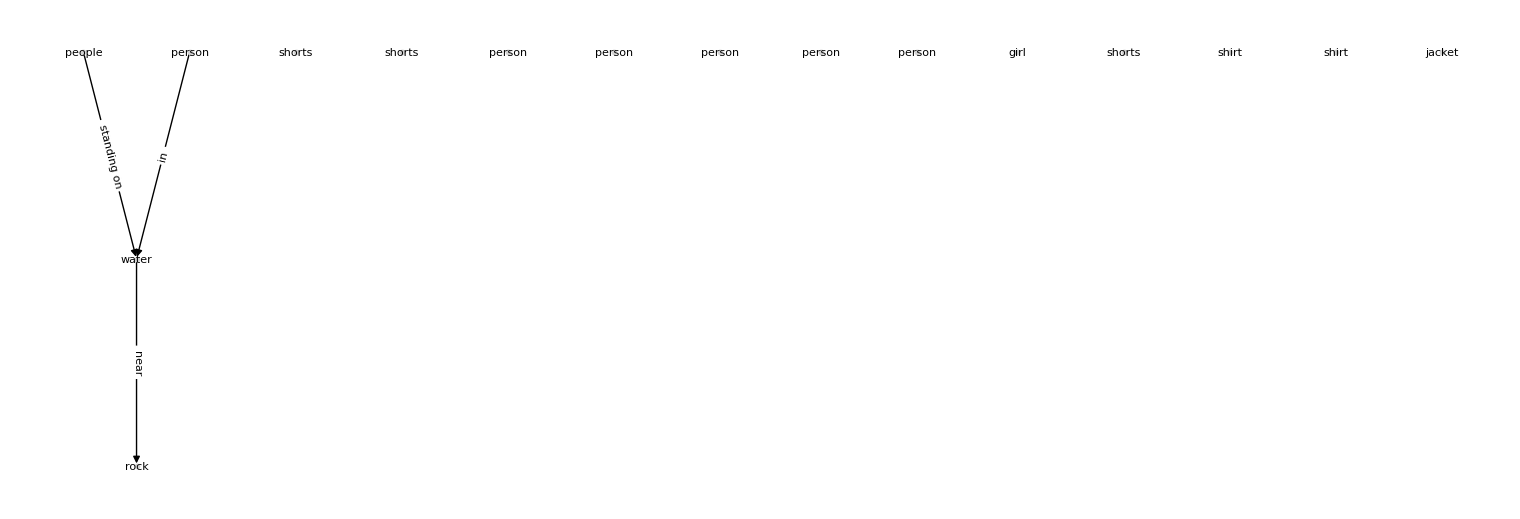

16230


In [9]:
def plot_graph(g):
    pos = nx.nx_agraph.graphviz_layout(g, prog="dot")
    max_y = max([y for x,y in pos.values()])
    n_nodes_top = len([n for n in g.nodes if pos[n][1] == max_y])
    longest_label = max([len(g.labels[n]) for n in g.nodes])
    plt.figure(figsize=(max(n_nodes_top*longest_label/10,15),5))
    nx.draw(g,pos=pos,labels=g.labels, with_labels=True, node_size=10, node_color="lightgray", font_size=8)
    nx.draw_networkx_edge_labels(g,pos=pos,edge_labels=nx.get_edge_attributes(g,'predicate'),font_size=8)
    plt.show()
print(f'there are now {len(filtered_graphs)} many graphs left')
print(f'example graph:')
import random
idx = random.randint(0,len(filtered_graphs))
plot_graph(filtered_graphs[idx])
print(idx)